In [1]:
from functools import partial

import hdbscan
import geoplot as gplt
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from shapely import geometry
from shapely.ops import transform
import pyproj

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# All public 311 data
# https://data.austintexas.gov/Utilities-and-City-Services/Austin-311-Public-Data/xwdj-i9he
# df = pd.read_csv('Austin_311_Public_Data_20180913.csv')
# look at only calls re: coyotes
# coyotes = df[df['SR Description'].str.match('.*coyote.*', case=False, na=False)]
# coyotes.to_csv('data/Austin_311_coyotes_20180913.csv')

In [3]:
coyotes = pd.read_csv('data/Austin_311_coyotes_20180913.csv')
coyotes.head(3)

,Unnamed: 0,Service Request (SR) Number,SR Description,Method Received,SR Status,Status Change Date,Created Date,Last Update Date,Close Date,SR Location,...,Zip Code,County,State Plane X Coordinate,State Plane Y Coordinate,Latitude Coordinate,Longitude Coordinate,(Latitude.Longitude),Council District,Map Page,Map Tile
0,35490,16-00307348,zCoyote Complaints,Phone,New,11/22/2016 10:22:45 AM,11/22/2016 10:22:45 AM,11/22/2016 10:22:45 AM,NaN,"7201 LEVANDER LOOP, AUSTIN, TX 78721",...,78721.0,TRAVIS,3.130986e+06,1.006508e+07,30.251394,-97.690434,"(30.25139382, -97.69043353)",3.0,616F,ML21
1,55637,17-00217599,Coyote Complaints,Phone,Closed,08/01/2017 01:54:24 PM,07/29/2017 09:56:33 AM,08/01/2017 01:54:24 PM,08/01/2017 01:54:24 PM,"MARYWOOD CIR & HARTNELL DR, AUSTIN, TX 78758",...,78723.0,TRAVIS,3.134979e+06,1.009081e+07,30.321849,-97.675846,"(30.32184946, -97.67584579)",1.0,556H,MM27
2,55673,17-00201267,Coyote Complaints,Phone,Closed,07/14/2017 04:25:17 PM,07/14/2017 03:19:30 PM,07/14/2017 04:25:17 PM,07/14/2017 04:25:17 PM,"8533 ADIRONDACK TRL, AUSTIN, TX 78759",...,78759.0,TRAVIS,3.106890e+06,1.011300e+07,30.384658,-97.763223,"(30.38465812, -97.76322266)",10.0,494Q,MH32


## add some reference data
Get some reference polygons, reproject to WGS84

In [4]:
travis_county = gpd.read_file('data/Boundary/Boundary.shp')
city_limits = gpd.read_file('data/Citylimits_Aug2018/Citylimits_Aug2018.shp')
austin = city_limits[city_limits.MUNI_NM == 'AUSTIN']
austin

,OBJECTID_1,OBJECTID,SOURCE,PROVIDER,LAST_MOD,EFF_DATE,POLY_ID,MUNIUNQID,COUNTRY,STATE,COUNTY,MUNI_NM,Shape_Leng,Shape__Are,Shape__Len,geometry
72,73,73,TRAVIS,CAPCOG911,2017-12-14T00:00:00.000Z,2018-08-01T00:00:00.000Z,73,73@CAPCOG911,US,TX,TRAVIS,AUSTIN,751273.06893,9.712516e+08,751272.839806,"(POLYGON ((-10866261.2198 3500944.9248, -10866..."


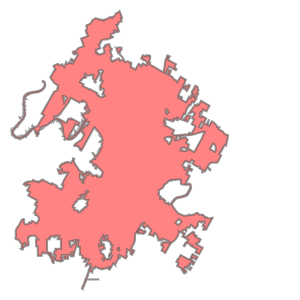

In [5]:
austin.iloc[0].geometry

In [6]:
travis_county.crs

{'proj': 'lcc',
 'lat_1': 30.11666666666667,
 'lat_2': 31.88333333333333,
 'lat_0': 29.66666666666667,
 'lon_0': -100.3333333333333,
 'x_0': 700000,
 'y_0': 3000000,
 'datum': 'NAD83',
 'units': 'us-ft',
 'no_defs': True}

In [7]:
# gpd reproject method #1
src_proj = pyproj.Proj(travis_county.crs, preserve_units=True)
dst_proj = pyproj.Proj(init='epsg:4326')
project = partial(pyproj.transform, src_proj, dst_proj)
travis_county_latlong = gpd.GeoDataFrame(travis_county, geometry=[transform(project, geometry.Polygon(travis_county.iloc[0].geometry))])

In [8]:
# reproject method #2
austin = austin.to_crs({'init': 'epsg:4326'})

### Plot the data

In [9]:
coyotes_gdf = gpd.GeoDataFrame(coyotes, 
                               geometry=list(geometry.MultiPoint(
                                   coyotes[["Longitude Coordinate", "Latitude Coordinate"]].values).geoms
                               
                               ),  
                               crs={"init": "epsg:4326"})

In [10]:
proj = gplt.crs.AlbersEqualArea(
    central_longitude=-97.6, 
    central_latitude=30.2
)

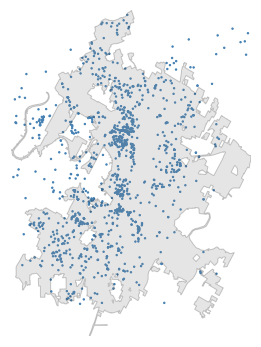

In [11]:
# ax = gplt.polyplot(
#     travis_county_latlong,
#     projection=proj,
#     zorder=-1,
# #     figsize=(12,12)
# )
ax = gplt.polyplot(
    austin,
    projection=proj,
    facecolor='gray', 
#     ax=ax,
    alpha=0.2
)
gplt.pointplot(
    coyotes_gdf,
    projection=proj,
    ax=ax,
    s=2, 
    alpha=1
)


## Find spatial clusters of coyote sightings using hbdscan
https://github.com/scikit-learn-contrib/hdbscan

In [12]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=50, 
    min_samples=1, 
    metric="haversine"
)

In [13]:
coords_radians = np.radians(
    coyotes_gdf[['Latitude Coordinate', 'Longitude Coordinate']].values   # x, y
)

coyotes_gdf['cluster_label'] = clusterer.fit_predict(coords_radians)

In [14]:
clusters = [
    geometry.MultiPoint(g[['Longitude Coordinate', 'Latitude Coordinate']].values).convex_hull 
    for l, g in coyotes_gdf.groupby("cluster_label") if l != -1
]

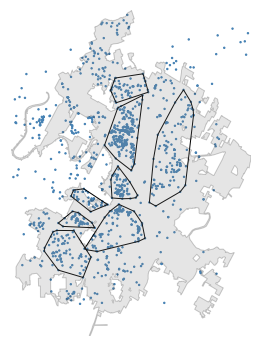

In [15]:
ax = gplt.polyplot(
    gpd.GeoSeries(
        clusters,
        crs={"init": "epsg:4326"}
    ),
    projection=proj
)
gplt.polyplot(
    austin,
    projection=proj,
    facecolor='gray', 
    ax=ax,
    alpha=0.2
)
gplt.pointplot(
    coyotes_gdf,
    projection=proj,
    ax=ax,
    s=2, 
    alpha=1
)
